In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Analyzing Titanic Dataset

Hi everyone. This is my serious take on challenging the Titanic Dataset: to see if I can predict the survival on once the British
Ocean Liner that sank in the early hours of 15 April 1912.

I will try to focus on improving the dataset in several iterations,
because I want to see from as many as possible angles how to reach the closest-to-perfection solution. 
But there's one thing that I will not try as my approach: deep learning, as I have physical restrictions on my currently-owned hardware.

## Load Dataset

In [64]:
df_train = pd.read_csv('input/train.csv')

display(df_train)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [65]:
df_test = pd.read_csv('input/test.csv')

display(df_test)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## Wrangling

Let's see what the data looks like through skimming process:

In [66]:
def skim_data(data):
    numeric_cols = set(data.select_dtypes(include=[np.number]).columns)
    numeric_stats = {}
    for col in numeric_cols:
        numeric_stats[col] = {
            'neg_%': round((data[col] < 0).mean() * 100, 3),
            'zero_%': round((data[col] == 0).mean() * 100, 3)
        }

    skimmed_data = pd.DataFrame({
        'feature': data.columns.values,
        'dtype': data.dtypes.astype(str).values,
        'null_%': round(data.isna().mean() * 100, 3).values,
        'negative_%': [numeric_stats.get(col, {}).get('neg_%', '-') for col in data.columns],
        'zero_%': [numeric_stats.get(col, {}).get('zero_%', '-') for col in data.columns],
        'n_unique': data.nunique().values,
        'unique_%': round(data.nunique() / len(data) * 100, 2).values,
        'sample_values': [list(data[col].dropna().unique()[:5]) for col in data.columns]
    })

    print(f'Total duplicate rows: {data.duplicated().sum()}')
    print(f'DF shape: {data.shape}')

    return skimmed_data

In [67]:
skim_data(df_train)

Total duplicate rows: 0
DF shape: (891, 12)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,PassengerId,int64,0.000,0.0,0.0,891,100.00,"[1, 2, 3, 4, 5]"
1,Survived,int64,0.000,0.0,61.616,2,0.22,"[0, 1]"
2,Pclass,int64,0.000,0.0,0.0,3,0.34,"[3, 1, 2]"
3,Name,object,0.000,-,-,891,100.00,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B..."
4,Sex,object,0.000,-,-,2,0.22,"[male, female]"
5,Age,float64,19.865,0.0,0.0,88,9.88,"[22.0, 38.0, 26.0, 35.0, 54.0]"
6,SibSp,int64,0.000,0.0,68.238,7,0.79,"[1, 0, 3, 4, 2]"
7,Parch,int64,0.000,0.0,76.094,7,0.79,"[0, 1, 2, 5, 3]"
8,Ticket,object,0.000,-,-,681,76.43,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803..."
9,Fare,float64,0.000,0.0,1.684,248,27.83,"[7.25, 71.2833, 7.925, 53.1, 8.05]"


In [68]:
skim_data(df_test)

Total duplicate rows: 0
DF shape: (418, 11)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,PassengerId,int64,0.000,0.0,0.0,418,100.00,"[892, 893, 894, 895, 896]"
1,Pclass,int64,0.000,0.0,0.0,3,0.72,"[3, 2, 1]"
2,Name,object,0.000,-,-,418,100.00,"[Kelly, Mr. James, Wilkes, Mrs. James (Ellen N..."
3,Sex,object,0.000,-,-,2,0.48,"[male, female]"
4,Age,float64,20.574,0.0,0.0,79,18.90,"[34.5, 47.0, 62.0, 27.0, 22.0]"
5,SibSp,int64,0.000,0.0,67.703,7,1.67,"[0, 1, 2, 3, 4]"
6,Parch,int64,0.000,0.0,77.512,8,1.91,"[0, 1, 3, 2, 4]"
7,Ticket,object,0.000,-,-,363,86.84,"[330911, 363272, 240276, 315154, 3101298]"
8,Fare,float64,0.239,0.0,0.478,169,40.43,"[7.8292, 7.0, 9.6875, 8.6625, 12.2875]"
9,Cabin,object,78.230,-,-,76,18.18,"[B45, E31, B57 B59 B63 B66, B36, A21]"


Based on the skimming result, there are no noticable error that I've seen on data: no negative values on any numeric-based features,
no null on any object-type features, etc. But, there are two things I want to take note of:

- The name also contains title and salutations (ex: Mr., Mrs., Rev., etc.)
- High amount of null values coming from `Age` and `Cabin` features

### `Title` in the `Name`

This part of work is inspired from the latest works I've seen on this challenge: [Megan L. Risdal](https://www.kaggle.com/code/mrisdal/exploring-survival-on-the-titanic/report) and 
[Aldemuro M. A. Haris](https://www.kaggle.com/code/aldemuro/comparing-ml-algorithms-train-accuracy-90/notebook).

After reading the works, I realized that title and salutations might worth even more than name itself; since salutations can closely 
describe one person's status. This explanation also works on the `Cabin` features, but I will explain this more on later.

Let's see if we can extract the titles from the name:

In [69]:
def title_extractor(df, col='Name'):
    return (
        df
        .assign(
            Title=lambda x: x[col].str.extract(r' ([A-Za-z]+)\.', expand=False)
        )
    )

df_train = title_extractor(df_train)

display(df_train.head())
display(df_train['Title'].unique())
display(skim_data(df_train))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

Total duplicate rows: 0
DF shape: (891, 13)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,PassengerId,int64,0.000,0.0,0.0,891,100.00,"[1, 2, 3, 4, 5]"
1,Survived,int64,0.000,0.0,61.616,2,0.22,"[0, 1]"
2,Pclass,int64,0.000,0.0,0.0,3,0.34,"[3, 1, 2]"
3,Name,object,0.000,-,-,891,100.00,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B..."
4,Sex,object,0.000,-,-,2,0.22,"[male, female]"
5,Age,float64,19.865,0.0,0.0,88,9.88,"[22.0, 38.0, 26.0, 35.0, 54.0]"
6,SibSp,int64,0.000,0.0,68.238,7,0.79,"[1, 0, 3, 4, 2]"
7,Parch,int64,0.000,0.0,76.094,7,0.79,"[0, 1, 2, 5, 3]"
8,Ticket,object,0.000,-,-,681,76.43,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803..."
9,Fare,float64,0.000,0.0,1.684,248,27.83,"[7.25, 71.2833, 7.925, 53.1, 8.05]"


We have a total of 17 different titles! Let's see the distributions.

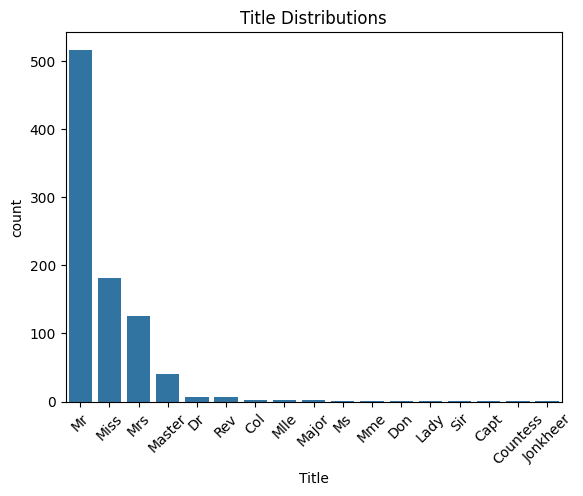

In [70]:
sns.countplot(data=df_train, x='Title', order=df_train['Title'].value_counts().index)
plt.title('Title Distributions')
plt.xticks(rotation=45)
plt.show()

We have a significant drop from the title `Master` and `Dr`, so I decide to use this as a defining line; the title that has count less 
than `Master` can be grouped into one. The previous works were grouped it into `Rare` group, so that's what I'm going to do as well.

But before doing that, I notice that `Ms`, `Mme`, and `Mlle` are quite similar; `Ms` is the short form of `Miss`, `Mme` is the short form of Madame, a French title similar to `Mrs`, and `Mlle` is the short form of Mademoiselle, a French title equivalent to `Miss` in English. Based on our findings, 
we will incorporate this changes into the previous function and generate a new `Title` distribution.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,dest_col
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Mr


Total duplicate rows: 0
DF shape: (891, 14)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,PassengerId,int64,0.000,0.0,0.0,891,100.00,"[1, 2, 3, 4, 5]"
1,Survived,int64,0.000,0.0,61.616,2,0.22,"[0, 1]"
2,Pclass,int64,0.000,0.0,0.0,3,0.34,"[3, 1, 2]"
3,Name,object,0.000,-,-,891,100.00,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B..."
4,Sex,object,0.000,-,-,2,0.22,"[male, female]"
5,Age,float64,19.865,0.0,0.0,88,9.88,"[22.0, 38.0, 26.0, 35.0, 54.0]"
6,SibSp,int64,0.000,0.0,68.238,7,0.79,"[1, 0, 3, 4, 2]"
7,Parch,int64,0.000,0.0,76.094,7,0.79,"[0, 1, 2, 5, 3]"
8,Ticket,object,0.000,-,-,681,76.43,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803..."
9,Fare,float64,0.000,0.0,1.684,248,27.83,"[7.25, 71.2833, 7.925, 53.1, 8.05]"


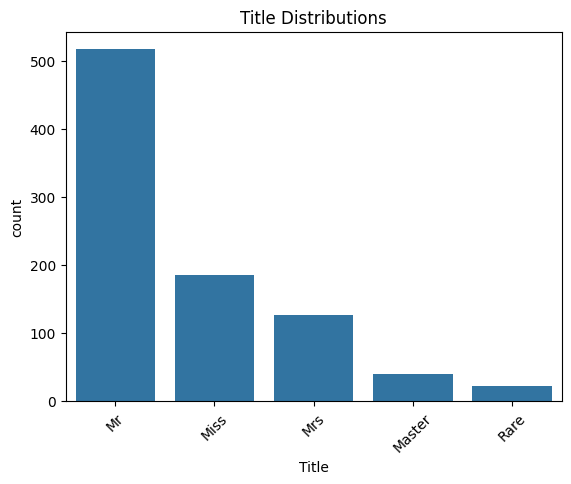

In [ ]:
def title_extractor(df, col='Name', dest_col='Title'):
    """
    This function extracts, cleans, and standardizes titles from a certain column and 
    put it in the destination column.

    Args:
    - df: The input dataframe.
    - col: A target column. Use 'Name' as the default.
    - dest_col: A destination column. Use 'Title` as the default.

    Returns:
        df: A dataframe with added values.
    """

    def clean_title(title):
        """A helper function to group titles."""
        if title in ['Ms', 'Mlle']:
            return 'Miss'
        if title in ['Mme']:
            return 'Mrs'
        return title

    """
    using `**` to tell Python to take the key-value pairs from the dict and
    treat them as if they were keyword=value arguments
    """
    return (
        df
        .assign(
            **{
                dest_col: lambda x: (
                    x[col]
                    .str.extract(r' ([A-Za-z]+)\.', expand=False)
                    .apply(clean_title)
                )
            }
        )
        .assign(
            **{
                dest_col: lambda x: (
                    x[dest_col].replace(
                        (counts := x[dest_col].value_counts())[counts < counts.get('Master', 0)].index,
                        'Rare'
                    )
                )
            }
        )
    )

df_train = title_extractor(df_train)

display(df_train.head())
display(skim_data(df_train))

sns.countplot(data=df_train, x='Title', order=df_train['Title'].value_counts().index)
plt.title('Title Distributions')
plt.xticks(rotation=45)
plt.show()

Now, let's see how our new feature relate to survival.

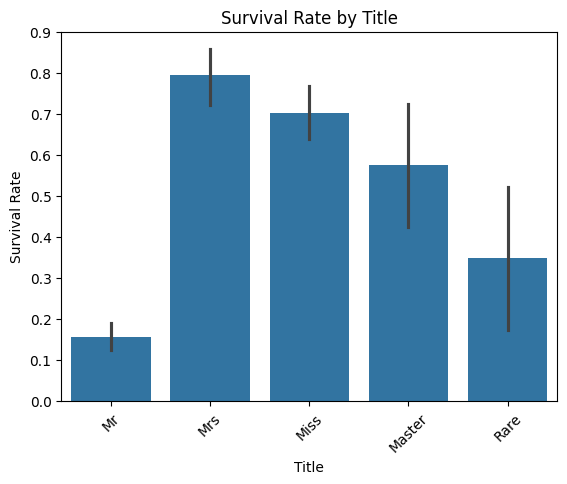

In [106]:
sns.barplot(x='Title', y='Survived', data=df_train)
plt.title('Survival Rate by Title')
plt.ylabel('Survival Rate')
plt.xticks(rotation=45)
plt.show()

### `Age` Feature

 

In [73]:
(
    df_train
    .groupby('Age', as_index=False)
    .agg(
        Count=('PassengerId', 'nunique')
    )
    .sort_values('Age')
)

,Age,Count
0,0.42,1
1,0.67,1
2,0.75,2
3,0.83,2
4,0.92,1
...,...,...
83,70.00,2
84,70.50,1
85,71.00,2
86,74.00,1


In [74]:
(
    df_train
    .loc[lambda x: x['Cabin'].notna()]
    .assign(
        CabinType=lambda x: x['Cabin']
    )
)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,dest_col,CabinType
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs,C85
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs,C123
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr,Mr,E46
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,Miss,Miss,G6
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,Miss,Miss,C103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S,Mrs,Mrs,D35
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S,Mr,Mr,B51 B53 B55
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C,Mrs,Mrs,C50
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss,Miss,B42


Everything seems normal but the amount of null percentage of `Age` and `Cabin` features are quite high.
Here is why I'm going to spent my resources on saving these features:

The end goal is to predict survival on Titanic, and I'd like to think that these two features are useful.
According to my quick search, there is a famous protocol that says, "women and children first" when it comes to safety.
I would expect a person's age to have a significant impact on survivability. Younger person should have a higher 
survival rate. On `Cabin`, it's not just a random, made-up words, it tells you where on the ship a person was located,
and implies their socio-economic status. People who stays on cabins located on upper deck might have easier access
to lifeboats other than those who in lower decks.

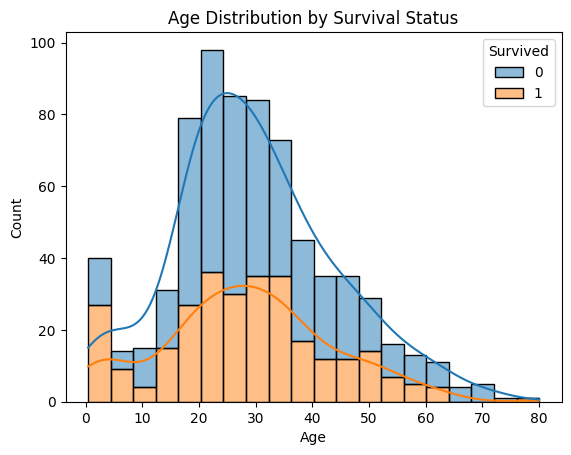

In [75]:
# plotting age distribution against survival

sns.histplot(data=df, x='Age', hue='Survived', kde=True, multiple='stack')
plt.title('Age Distribution by Survival Status')
plt.show()

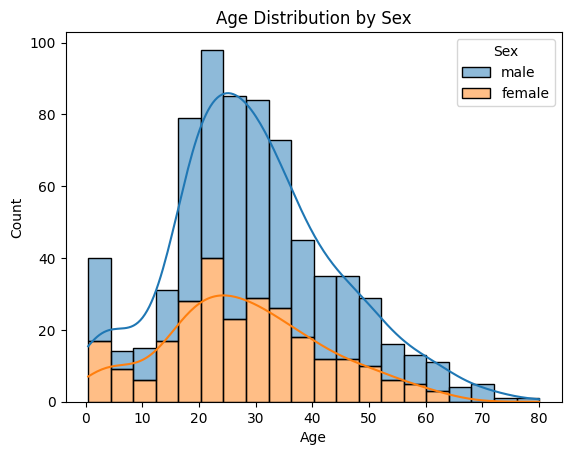

In [76]:
# plotting age distribution against sex

sns.histplot(data=df, x='Age', hue='Sex', kde=True, multiple='stack')
plt.title('Age Distribution by Sex')
plt.show()

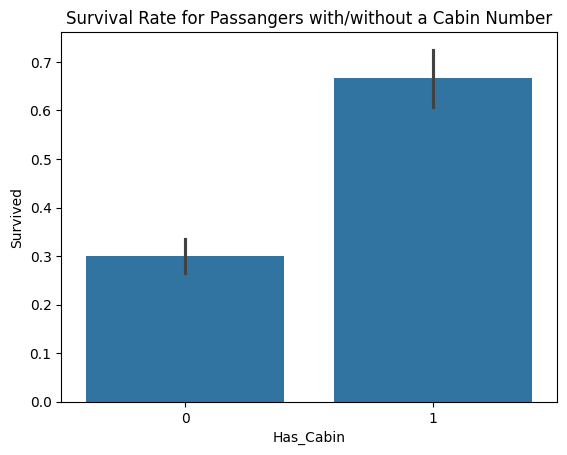

In [77]:
# plotting having a cabin against survival

df_cabin = df.copy()
df_cabin['Has_Cabin'] = df_cabin['Cabin'].notna().astype(int)

sns.barplot(data=df_cabin, x='Has_Cabin', y='Survived')
plt.title('Survival Rate for Passangers with/without a Cabin Number')
plt.show()

### Age Imputation